In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings("ignore")

forest="Bird_Monitoring_Data_FOREST.XLSX"
grassland="Bird_Monitoring_Data_GRASSLAND.XLSX"

forest_dic=pd.read_excel(forest,sheet_name=None)
grassland_dic=pd.read_excel(grassland,sheet_name=None)

forest_df=pd.concat(forest_dic.values(),ignore_index=True)
grassland_df=pd.concat(grassland_dic.values(),ignore_index=True)

data=pd.concat([forest_df , grassland_df], ignore_index=True)

# Data Cleaning and Preprocessing

data['Distance'] = data['Distance'].str.strip().replace({'  ': ' '}, regex=True)
distance_mapping = {'<= 50 Meters': 25,  '50 - 100 Meters': 75}
data['Distance'] = data['Distance'].map(distance_mapping)

data.drop(columns=["Sub_Unit_Code","NPSTaxonCode"],inplace=True)
data['Site_Name'].fillna("Unknown",inplace=True)
data['ID_Method'].fillna(data["ID_Method"].mode()[0],inplace=True)
data['Distance']=pd.to_numeric(data['Distance'],errors='coerce')
data['Distance'].fillna(data["Distance"].median(),inplace=True)
data['Sex'].fillna("Undetermined",inplace=True)
data['AcceptedTSN'].fillna(data['AcceptedTSN'].mode()[0],inplace=True)
data['TaxonCode'].fillna(data['TaxonCode'].mode()[0],inplace=True)
data['Previously_Obs'].fillna(data['Previously_Obs'].mode()[0], inplace=True)

data[data.duplicated()]

data.drop_duplicates(inplace=True)
data.duplicated().sum()
data['Year'].astype(int)
data['Temperature'].astype(float)
data['Year'].astype(int)
data['Visit'].astype(int)



1.Temporal Analysis
Seasonal Trends: Analyze the Date and Year columns to detect patterns in bird sightings across different seasons or years.

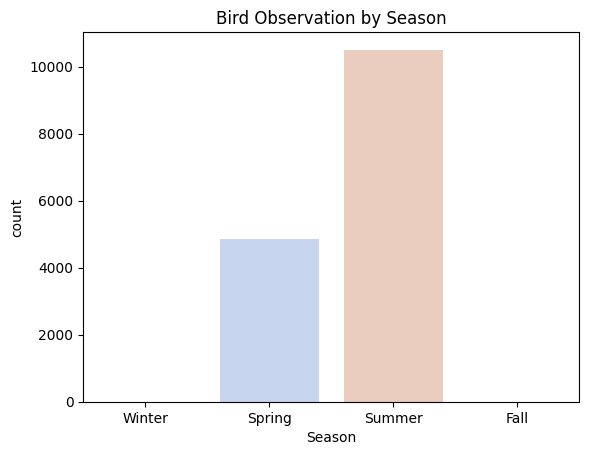

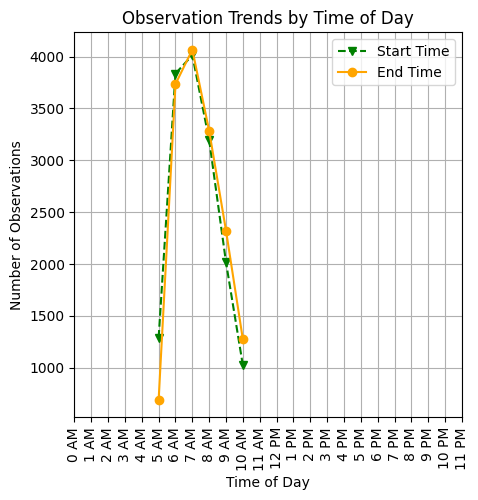

In [32]:
data['Date']=pd.to_datetime(data['Date'])
data['Month']=data['Date'].dt.month
data['Season']=data['Month'].map({12: 'Winter', 1: 'Winter', 2: 'Winter',
                                    3: 'Spring', 4: 'Spring', 5: 'Spring',
                                    6: 'Summer', 7: 'Summer', 8: 'Summer',
                                    9: 'Fall', 10: 'Fall', 11: 'Fall'})


# a).Bird sightings per month/season:
sns.countplot(x='Season',data=data,order=['Winter','Spring','Summer','Fall'],palette='coolwarm')
plt.title("Bird Observation by Season")
plt.show

# b).Observation Time Analysis:

data['Start_Time']=pd.to_datetime(data['Start_Time'],format='%H:%M:%S', errors='coerce')
data['End_Time']=pd.to_datetime(data['End_Time'],format='%H:%M:%S', errors='coerce')

data['start_hour']=data['Start_Time'].dt.hour
data['end_hour']=data['End_Time'].dt.hour

start_distribution=data['start_hour'].value_counts().sort_index()
end_distribution=data['end_hour'].value_counts().sort_index()

hour_labels = [f"{h} AM" if h < 12 else ("12 PM" if h == 12 else f"{h-12} PM") for h in range(24)]

plt.figure(figsize=(5,5))
plt.plot(start_distribution.index,start_distribution.values,marker='v',linestyle='--',color='g',label="Start Time")
plt.plot(end_distribution.index,end_distribution.values,marker='o',linestyle='-',color='orange',label="End Time")
plt.xticks(range(24), hour_labels, rotation=90)  
plt.title("Observation Trends by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Number of Observations")
plt.legend()
plt.grid(True)
plt.show()


2.Spatial Analysis
●	Location Insights: Group data by Location_Type (e.g., Grassland) to identify biodiversity hotspots.
●	Plot-Level Analysis: Compare observations across different Plot_Name to see which plots attract more species or specific kinds of birds.

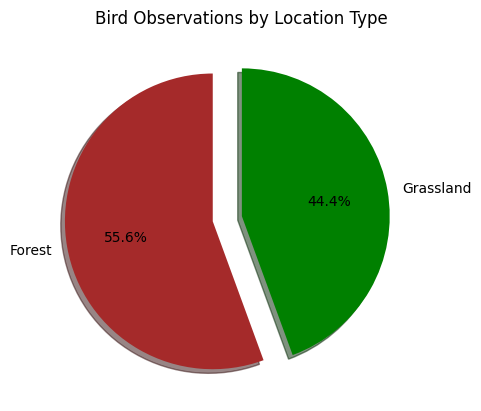

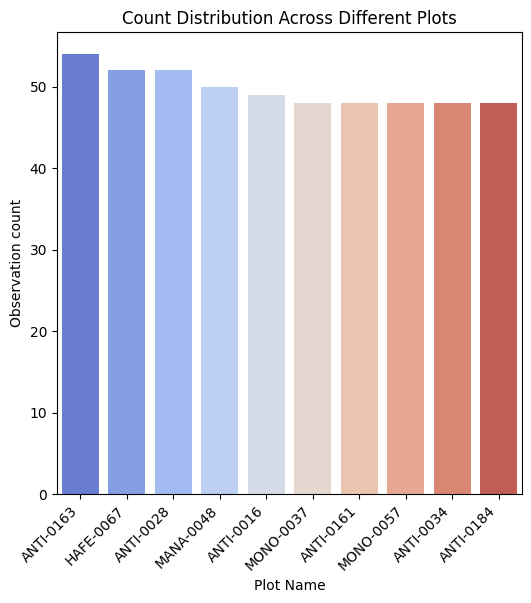

In [5]:
biodiversity=data['Location_Type'].value_counts()
plt.Figure(figsize=(6,6))
color=['brown','green']
explode=(0.2,0)
plt.title("Bird Observations by Location Type")
plt.pie(
    biodiversity.values,
    labels=biodiversity.index,
    colors=color,
    autopct='%1.1f%%',
    shadow=True,
    explode=explode,
    startangle=90
    )
top_plots=data['Plot_Name'].value_counts().nlargest(10)
plt.figure(figsize=(6,6))
sns.barplot(x=top_plots.index, y=top_plots.values, palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Plot Name")
plt.ylabel("Observation count")
plt.title("Count Distribution Across Different Plots")
plt.show()


3. Species Analysis
●	Diversity Metrics: Count unique species (Scientific_Name) observed and their distribution across Location_Type.
●	Activity Patterns: Check the Interval_Length and ID_Method columns to identify the most common activity types (e.g., Singing).
●	Sex Ratio: Analyze the Sex column to understand the male-to-female ratio for different species.

Total no of unique Spices = 127


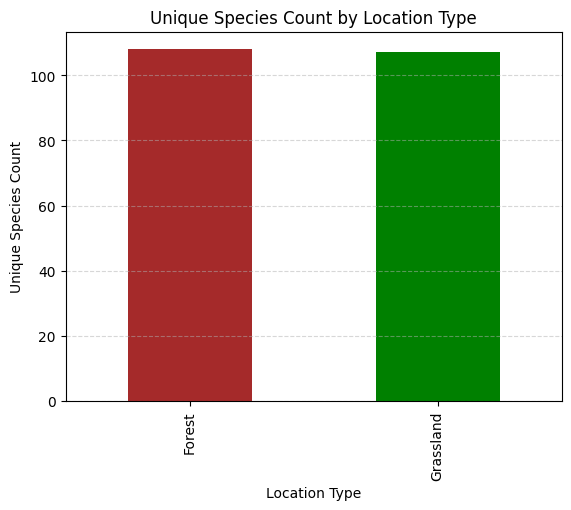

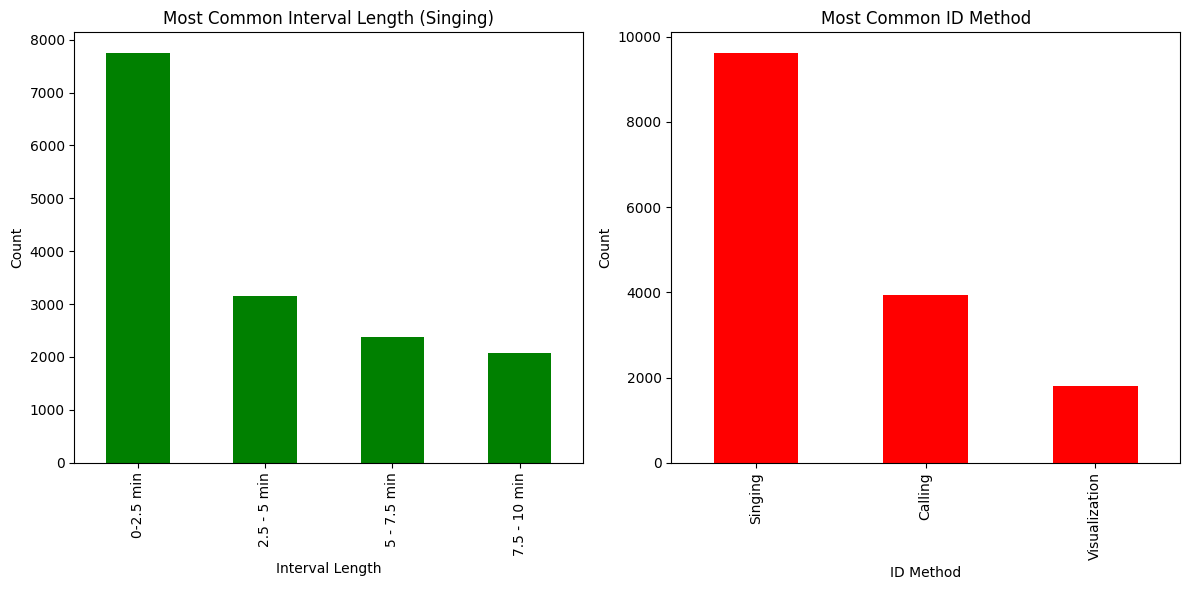

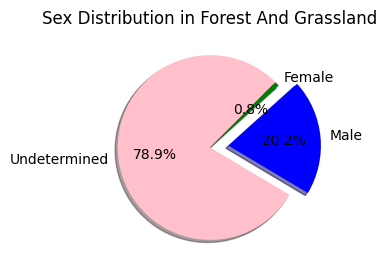

In [6]:
print("Total no of unique Spices =",data['Scientific_Name'].nunique())
location_spices=data.groupby("Location_Type")['Scientific_Name'].nunique()
location_spices.plot(kind='bar',color=['brown','green'])
plt.title("Unique Species Count by Location Type")
plt.xlabel("Location Type")
plt.ylabel("Unique Species Count")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First plot: Interval Length
data['Interval_Length'].value_counts().plot(kind='bar', ax=axes[0], color='green')
axes[0].set_title("Most Common Interval Length (Singing)")
axes[0].set_xlabel("Interval Length")
axes[0].set_ylabel("Count")

# Second plot: ID Method
data['ID_Method'].value_counts().plot(kind='bar', ax=axes[1], color='red')
axes[1].set_title("Most Common ID Method")
axes[1].set_xlabel("ID Method")
axes[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

sex_ratio=data['Sex'].value_counts()
plt.figure(figsize=(3,3))
plt.pie(sex_ratio,labels=sex_ratio.index,autopct='%1.1f%%', colors=['pink', 'blue', 'green'], startangle=45,shadow=True,
    explode=(0,0.2,0)
    )
plt.title("Sex Distribution in Forest And Grassland")
plt.show()




4. Environmental Conditions
●	Weather Correlation: Explore how Temperature, Humidity, Sky, and Wind impact observations, such as the number of birds or their distances.
●	Disturbance Effect: Assess the impact of Disturbance (e.g., slight effect) on bird sightings.


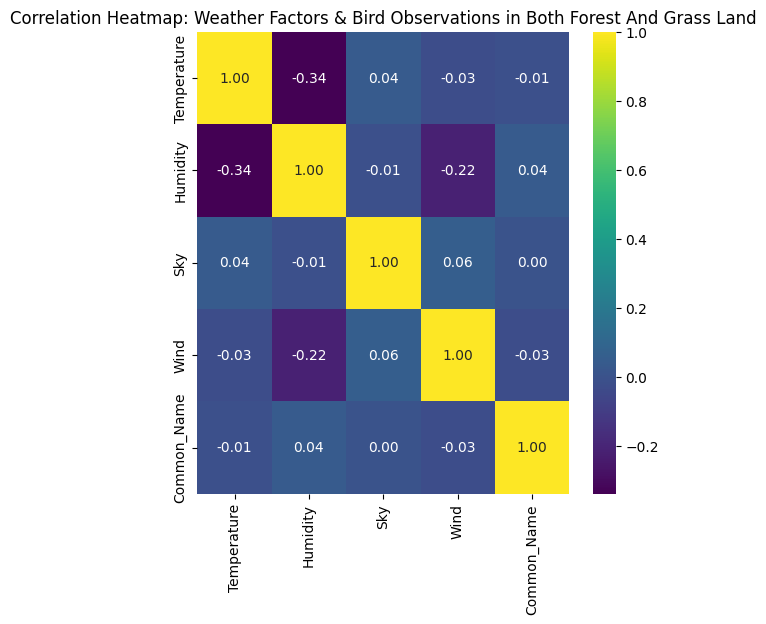

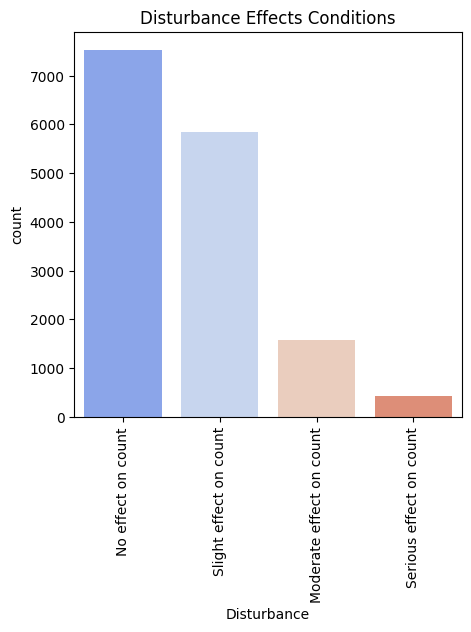

In [7]:
lbl=LabelEncoder()
data['Common_Name']=lbl.fit_transform(data['Common_Name'])
data['Sky']=lbl.fit_transform(data['Sky'])
data['Wind']=lbl.fit_transform(data['Wind'])
cols=['Temperature','Humidity','Sky','Wind','Common_Name']
plt.figure(figsize=(6, 6))
sns.heatmap(data[cols].corr(), annot=True, cmap="viridis", fmt=".2f")
plt.title("Correlation Heatmap: Weather Factors & Bird Observations in Both Forest And Grass Land")
plt.show()

plt.figure(figsize=(5,5))
sns.countplot(data=data,x='Disturbance',order=data["Disturbance"].value_counts().index,palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Disturbance Effects Conditions")
plt.show()

5. Distance and Behavior
●	Distance Analysis: Evaluate the Distance column to identify species typically observed closer or farther from the observer.
●	Flyover Frequency: Examine the Flyover_Observed column to detect trends in bird behavior during observation.


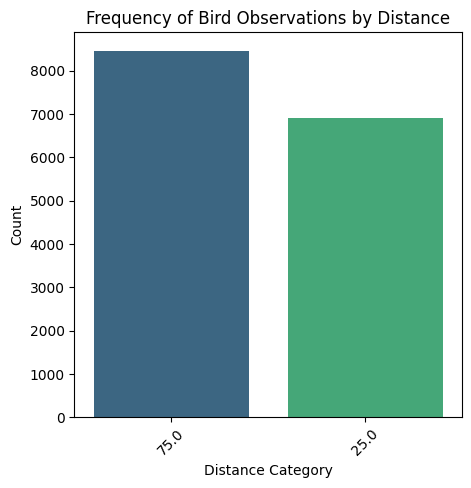

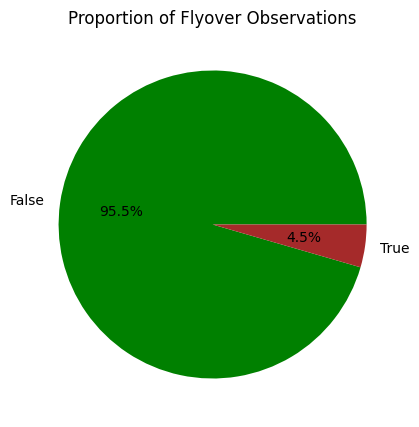

In [8]:
plt.figure(figsize=(5, 5))
sns.countplot(data=data, x="Distance", order=data["Distance"].value_counts().index, palette="viridis")
plt.title("Frequency of Bird Observations by Distance")
plt.xlabel("Distance Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(5, 5))
data["Flyover_Observed"].value_counts().plot.pie(autopct="%1.1f%%", colors=["green", "brown"])
plt.title("Proportion of Flyover Observations")
plt.ylabel("") 
plt.show()

6. Observer Trends
●	Observer Bias: Analyze data by Observer to check if specific individuals report more observations or certain species.
●	Visit Patterns: Evaluate the Visit column to see how repeated visits affect species count or diversity

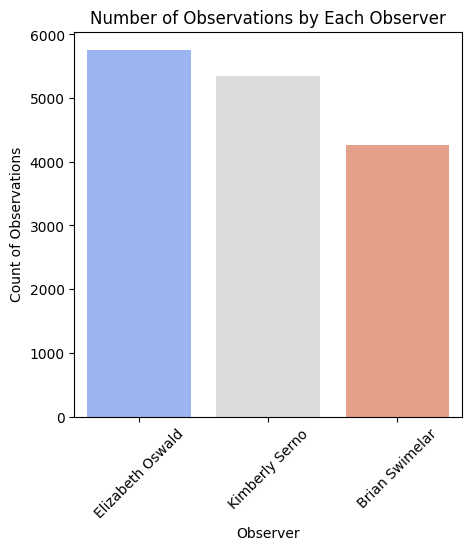

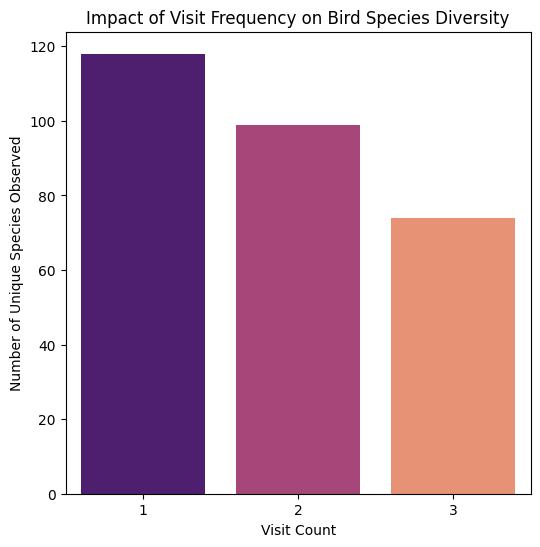

In [9]:
plt.figure(figsize=(5, 5))
sns.countplot(data=data, x="Observer", order=data["Observer"].value_counts().index, palette="coolwarm")
plt.title("Number of Observations by Each Observer")
plt.xlabel("Observer")
plt.ylabel("Count of Observations")
plt.xticks(rotation=45)
plt.show()

visit_species_count = data.groupby("Visit")["Common_Name"].nunique().reset_index()
visit_species_count.columns = ["Visit", "Unique Species Count"]
plt.figure(figsize=(6, 6))
sns.barplot(data=visit_species_count, x="Visit", y="Unique Species Count", palette="magma")
plt.title("Impact of Visit Frequency on Bird Species Diversity")
plt.xlabel("Visit Count")
plt.ylabel("Number of Unique Species Observed")
plt.show()

7. Conservation Insights
●	Watchlist Trends: Use the PIF_Watchlist_Status and Regional_Stewardship_Status to identify trends in species that are at risk or require conservation focus.
●	AOU Code Patterns: Study the distribution of species based on their AOU_Code to correlate with regional or national conservation priorities


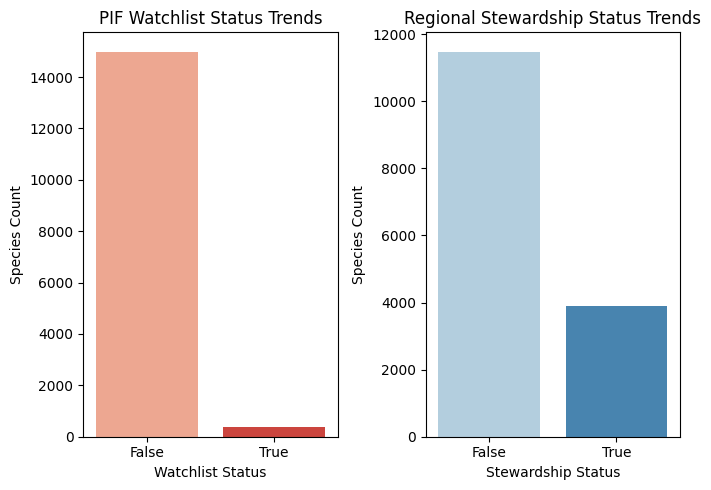

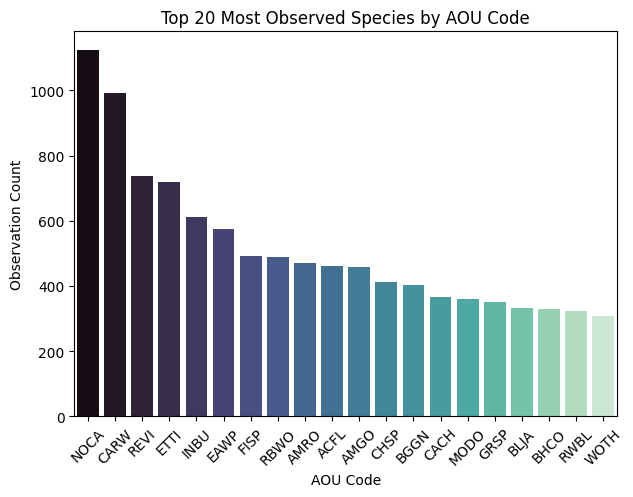

In [10]:
watchlist_counts = data["PIF_Watchlist_Status"].value_counts().reset_index()
watchlist_counts.columns = ["Status", "Count"]

# Count the occurrences of each status in Regional_Stewardship_Status
stewardship_counts = data["Regional_Stewardship_Status"].value_counts().reset_index()
stewardship_counts.columns = ["Status", "Count"]

# Plot PIF Watchlist Trends
plt.figure(figsize=(7, 5))
plt.subplot(1, 2, 1)
sns.barplot(data=watchlist_counts, x="Status", y="Count", palette="Reds")
plt.title("PIF Watchlist Status Trends")
plt.xlabel("Watchlist Status")
plt.ylabel("Species Count")

# Plot Regional Stewardship Trends
plt.subplot(1, 2, 2)
sns.barplot(data=stewardship_counts, x="Status", y="Count", palette="Blues")
plt.title("Regional Stewardship Status Trends")
plt.xlabel("Stewardship Status")
plt.ylabel("Species Count")

plt.tight_layout()
plt.show()


aou_counts = data["AOU_Code"].value_counts().reset_index()
aou_counts.columns = ["AOU_Code", "Count"]
plt.figure(figsize=(7, 5))
sns.barplot(data=aou_counts.head(20), x="AOU_Code", y="Count", palette="mako")
plt.title("Top 20 Most Observed Species by AOU Code")
plt.xlabel("AOU Code")
plt.ylabel("Observation Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
import mysql.connector

mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="NanDha@12345",
    database="bird",
    auth_plugin='mysql_native_password'
)

cursor = mydb.cursor()

cursor.execute(""" 
CREATE TABLE BirdObservations (
    Admin_Unit_Code VARCHAR(50),
    Site_Name VARCHAR(255),
    Plot_Name VARCHAR(255),
    Location_Type VARCHAR(100),
    Year VARCHAR(10),
    Date DATE,
    Start_Time TIME,
    End_Time TIME,
    Observer VARCHAR(255),
    Visit VARCHAR(50),
    Interval_Length VARCHAR(50),
    ID_Method VARCHAR(100),
    Distance FLOAT,
    Flyover_Observed VARCHAR(50),
    Sex VARCHAR(50),
    Common_Name INT,
    Scientific_Name VARCHAR(255),
    AcceptedTSN FLOAT,
    AOU_Code VARCHAR(50),
    PIF_Watchlist_Status VARCHAR(100),
    Regional_Stewardship_Status VARCHAR(100),
    Temperature FLOAT,
    Humidity FLOAT,
    Sky INT,
    Wind INT,
    Disturbance VARCHAR(100),
    Initial_Three_Min_Cnt VARCHAR(50),
    TaxonCode FLOAT,
    Previously_Obs BOOLEAN,
    Month INT,
    Season VARCHAR(50),
    start_hour INT,
    end_hour INT
);
""")


In [ ]:
import mysql.connector
import pandas as pd

columns = [
    "Admin_Unit_Code", "Site_Name", "Plot_Name", "Location_Type", "Year", "Date",
    "Start_Time", "End_Time", "Observer", "Visit", "Interval_Length", "ID_Method",
    "Distance", "Flyover_Observed", "Sex", "Common_Name", "Scientific_Name",
    "AcceptedTSN", "AOU_Code", "PIF_Watchlist_Status", "Regional_Stewardship_Status",
    "Temperature", "Humidity", "Sky", "Wind", "Disturbance", "Initial_Three_Min_Cnt",
    "TaxonCode", "Previously_Obs", "Month", "Season", "start_hour", "end_hour"
]
df = data[columns]

# Convert DataFrame to list of tuples
data = [tuple(row) for row in df.to_numpy()]

# Connect to MySQL
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="NanDha@12345",
    database="bird",
    auth_plugin='mysql_native_password'
)
cursor = mydb.cursor()

# SQL INSERT statement
insert_query = """
INSERT INTO BirdObservations (
    Admin_Unit_Code, Site_Name, Plot_Name, Location_Type, Year, Date,
    Start_Time, End_Time, Observer, Visit, Interval_Length, ID_Method,
    Distance, Flyover_Observed, Sex, Common_Name, Scientific_Name,
    AcceptedTSN, AOU_Code, PIF_Watchlist_Status, Regional_Stewardship_Status,
    Temperature, Humidity, Sky, Wind, Disturbance, Initial_Three_Min_Cnt,
    TaxonCode, Previously_Obs, Month, Season, start_hour, end_hour
) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,
          %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
"""

# Execute and commit
cursor.executemany(insert_query, data)
mydb.commit()

# Close connections
cursor.close()
mydb.close()